This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.
In case you are facing issues, please read the following two documents first:
https://github.com/IBM/skillsnetwork/wiki/Environment-Setup
https://github.com/IBM/skillsnetwork/wiki/FAQ
Then, please feel free to ask:
https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all
Please make sure to follow the guidelines before asking a question:
https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me
If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('## <span style="color:green">'+string+'</span>'))
    
if ('sc' in locals() or 'sc' in globals()):
    printmd("ERROR!!")
else:
    printmd("All is good!")

## <span style="color:green">All is good!</span>

In [4]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 66.3MB/s eta 0:00:017MB 13.5MB/s eta 0:00:14��█████▊                    | 79.8MB 7.1MB/s eta 0:00:20�██████████▉                | 107.6MB 63.4MB/s eta 0:00:02MB/s eta 0:00:01
     |████████████████████████████████| 204kB 56.4MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [7]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [8]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()


# Exercise 3.1
Welcome to Exercise 3.
Now it is time to grab a PARQUET file and create a dataframe out of it. Using SparkSQL you can handle it like a database.

In [9]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-12-20 00:57:00--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-12-20 00:57:00--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-12-20 00:57:00--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [11]:
df = spark.read.parquet("washing.parquet")

In [13]:
df.count()

2058

In [15]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [22]:
result = spark.sql("SELECT voltage FROM washing WHERE voltage IS NOT NULL")
result_array = result.rdd.map(lambda row : row.voltage).sample(False, 0.1).collect()
result_array[:15]

[228, 224, 225, 235, 220, 232, 226, 224, 234, 234, 232, 229, 233, 237, 231]

Now it's time to plot the python list by importing the matplotlib library, calling "boxplot" and "show". Note that you can see mean (red line) around 230. Then you see that 50% of all values are between 225 and 235 (blue box). Per default values up to 250 are not seen as outliers (little, black horizontal line). And the "plus" symbols on top are definitely outliers. Congratulations, you've written your first anomaly detection algorithm. Unfurtunately you still need a brain attached to it, so we'll cover on how we write one without a brain needed in the next course. And in the course after that we'll even tell you how to implement a artificial brain to further improve it, so stay tuned :)

In [24]:
%matplotlib inline

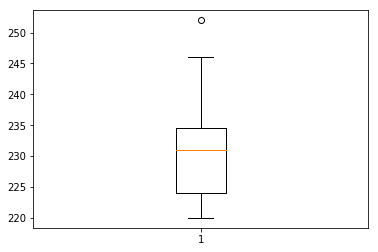

In [26]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

In [28]:
result = spark.sql('SELECT voltage, ts FROM washing WHERE voltage IS NOT NULL ORDER BY ts ASC')
result_rdd = result.rdd.sample(False,0.1).map(lambda row: (row.ts, row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage : ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage : ts_voltage[1]).collect()

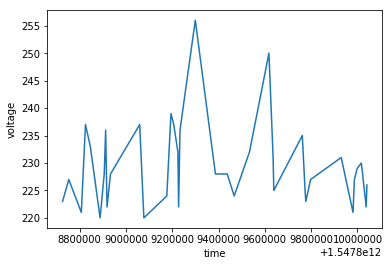

In [29]:
plt.plot(result_array_ts, result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [30]:
spark.sql("SELECT max(ts) AS max_ts, min(ts) AS min_ts FROM washing").show()

+-------------+-------------+
|       max_ts|       min_ts|
+-------------+-------------+
|1547810064867|1547808720911|
+-------------+-------------+




Now lets repeat the previous steps but only show data for hour. We've found out the low and high boundary of data available and we know that "ts" stand for "timestamp". Timestamp are the number of millisecons passed since the 1st of Jan. 1970. You can also use an online tool like http://www.epochconverter.com/ to convert these. But for now just an interval of 60 minutes (10006060)=3600000 within the range above (note that we have removed the sample function because the data set is already reduced)

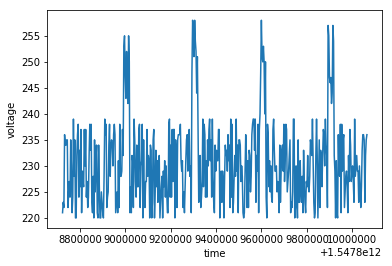

In [33]:
result = spark.sql(
"""
    SELECT voltage
        , ts
    FROM washing
    WHERE voltage IS NOT NULL AND
    ts > 1547808720911 AND
    ts <= 1547810064867+3600000
    ORDER BY ts ASC
"""
)
result_rdd = result.rdd.map(lambda row : (row.ts, row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage : ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage : ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

As you can see we are not only able to spot the outliers but also see a time pattern of these outliers occuring which can be used for further downstream analysis. Again your brain was already capable of spotting the pattern. In the next two coursera courses we will teach a machine to spot those patterns as well.
Now we've plotted a maximum of two dimensions at a time, let's go for three in a so-called 3D scatter plot. Again we have to create python lists (with applied sampling if necessary) from three properties of our data.

In [43]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

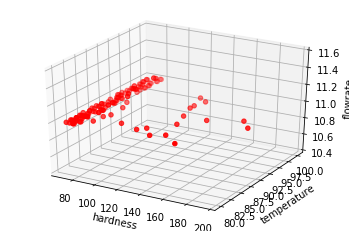

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()